# Notebook for bidirectional RNN model

In [1]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util_funcs import load_split_data
from sentence_transformers import SentenceTransformer

from keras.layers import LSTM, GRU, Dense, LayerNormalization, Bidirectional, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping

In [2]:
# setup PyTorch backend
import os
os.environ['KERAS_BACKEND'] = 'torch'
import torch
print("Using PyTorch backend")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}")

Using PyTorch backend
Using device: cuda


In [ ]:
# generate data splits
X_train, X_val, X_test, y_train, y_val, y_test = load_split_data("../data/Sentiment_Analysis.csv")

## Sequence embeddings

In [4]:
# embedding model
emb_model = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
# pad sequences
import nltk
nltk.download("punkt_tab")
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences

def process_text_sequences(max_length=40, padding='post', truncating='post'):
    """
    Convert texts to padded sequences of tokens.

    Args:
        max_length: Maximum sequence length (default: 40)
        padding: 'pre' or 'post' padding (default: 'post')
        truncating: 'pre' or 'post' truncation (default: 'post')

    Returns:
        X_train_padded: Padded training sequences
        X_val_padded: Padded validation sequences
        X_test_padded: Padded test sequences
    """
    data = [X_train, X_val, X_test]
    padded_sequences = []

    for texts in data:
        # Tokenize all texts
        sequences = [word_tokenize(text) for text in texts]

        # Convert tokens to numpy arrays with padding
        padded_sequences.append(pad_sequences(
            sequences=[s[:max_length] for s in sequences],  # Truncate if needed
            maxlen=max_length,
            padding=padding,
            truncating=truncating,
            dtype=object,  # Use object dtype for string tokens
            value=''  # Use empty string as padding token
        ))

    return tuple(padded_sequences)

X_train_padded, X_val_padded, X_test_padded = process_text_sequences()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [6]:
from functools import cache
@cache
def encode_words(model, text):
    return model.encode(text)

In [7]:
# convert padded sequences to embeddings
def create_embedding_sequences(model, max_length=40):
    """
    Convert sequences of words to sequences of embeddings using cached word vectors.
    Ensures all sequences have the same length through padding.

    Args:
        model: SentenceTransformer model
        max_length: Maximum sequence length (default: 40)
    Returns:
        X_train_embedded: Training embeddings
        X_val_embedded: Validation embeddings
        X_test_embedded: Test embeddings
    """
    data = [X_train_padded, X_val_padded, X_test_padded]
    embeddings = []
    embedding_dim = model.get_sentence_embedding_dimension()

    for sequences in data:
        n_sequences = len(sequences)

        # Initialize the output array with zeros
        embedded_seqs = np.zeros((n_sequences, max_length, embedding_dim))

        for i, seq in enumerate(sequences):
            # Get embeddings for non-empty tokens
            valid_tokens = [word for word in seq if word != '']
            # Truncate if necessary
            valid_tokens = valid_tokens[:max_length]
            # Create embeddings for valid tokens
            seq_embeddings = [encode_words(model, word) for word in valid_tokens]

            # Add embeddings to the output array with padding
            for j, embedding in enumerate(seq_embeddings):
                if j < max_length:
                    embedded_seqs[i, j] = embedding
        embeddings.append(embedded_seqs)
        print(f"Shape: {embedded_seqs.shape}")

    return tuple(embeddings)

In [8]:
%%time
# generate sequence embeddings
X_train_embedded, X_val_embedded, X_test_embedded = create_embedding_sequences(emb_model)

Shape: (24000, 40, 384)
Shape: (8000, 40, 384)
Shape: (8000, 40, 384)
CPU times: user 5min 9s, sys: 1.5 s, total: 5min 11s
Wall time: 5min 11s


## LSTM

In [9]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [10]:
# model 1
lstm_1 = Sequential([
    Bidirectional(LSTM(16), input_shape=(40, 384)),
    LayerNormalization(),
    Dense(16, activation='relu'),
    Dense(13, activation='softmax')
])

lstm_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_1.summary()
lstm_1_history = lstm_1.fit(X_train_embedded, y_train, validation_data=(X_val_embedded, y_val), epochs=30, callbacks=[early_stop])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 32)             │        51,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,141 (203.68 KB)

 Trainable params: 52,141 (203.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.2116 - loss: 2.2259 - val_accuracy: 0.3296 - val_loss: 1.9439
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3327 - loss: 1.9304 - val_accuracy: 0.3195 - val_loss: 1.9345
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3442 - loss: 1.8884 - val_accuracy: 0.3575 - val_loss: 1.8795
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3630 - loss: 1.8504 - val_accuracy: 0.3605 - val_loss: 1.8693
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3680 - loss: 1.8402 - val_accuracy: 0.3636 - val_loss: 1.8619
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3744 - loss: 1.8247 - val_accuracy: 0.3730 - val_loss: 1.8552
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3764 - loss: 1.8126 - val_accuracy: 0.3674 - val_loss: 1.8625
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3823 - loss: 1.7865 - val_accuracy: 

In [11]:
# model 2
lstm_2 = Sequential([
    Bidirectional(LSTM(32, return_sequences=True), input_shape=(40, 384)),
    LayerNormalization(),
    Bidirectional(LSTM(16)),
    LayerNormalization(),
    Dense(16, activation='relu'),
    Dense(13, activation='softmax')
])

lstm_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_2.summary()
lstm_2_history = lstm_2.fit(X_train_embedded, y_train, validation_data=(X_val_embedded, y_val), epochs=30, callbacks=[early_stop])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 40, 64)         │       106,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 40, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,061 (461.18 KB)

 Trainable params: 118,061 (461.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.2571 - loss: 2.1895 - val_accuracy: 0.3279 - val_loss: 1.9504
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3375 - loss: 1.9411 - val_accuracy: 0.3512 - val_loss: 1.9031
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3588 - loss: 1.8906 - val_accuracy: 0.3555 - val_loss: 1.8782
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3669 - loss: 1.8455 - val_accuracy: 0.3621 - val_loss: 1.8583
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3781 - loss: 1.8217 - val_accuracy: 0.3636 - val_loss: 1.8553
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3897 - loss: 1.7898 - val_accuracy: 0.3766 - val_loss: 1.8400
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3952 - loss: 1.7646 - val_accuracy: 0.3786 - val_loss: 1.8409
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4132 - loss: 1.7223 - 

In [12]:
# model 3
lstm_3 = Sequential([
    Bidirectional(LSTM(32, return_sequences=True), input_shape=(40, 384)),
    LayerNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(16)),
    LayerNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(13, activation='softmax')
])

lstm_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_3.summary()
lstm_3_history = lstm_3.fit(X_train_embedded, y_train, validation_data=(X_val_embedded, y_val), epochs=30, callbacks=[early_stop])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (None, 40, 64)         │       106,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 40, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,061 (461.18 KB)

 Trainable params: 118,061 (461.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.2284 - loss: 2.2455 - val_accuracy: 0.2828 - val_loss: 2.0969
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.2782 - loss: 2.1019 - val_accuracy: 0.3158 - val_loss: 1.9828
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3241 - loss: 1.9885 - val_accuracy: 0.3416 - val_loss: 1.9529
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3393 - loss: 1.9428 - val_accuracy: 0.3436 - val_loss: 1.9102
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3506 - loss: 1.9151 - val_accuracy: 0.3629 - val_loss: 1.8942
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3557 - loss: 1.8970 - val_accuracy: 0.3530 - val_loss: 1.9146
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3644 - loss: 1.8853 - val_accuracy: 0.3650 - val_loss: 1.8746
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3629 - loss: 1.8705 - 

In [13]:
# model 4
lstm_4 = Sequential([
    Bidirectional(LSTM(32, return_sequences=True), input_shape=(40, 384)),
    LayerNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(16, return_sequences=True)),
    LayerNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(16)),
    LayerNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(13, activation='softmax')
])

lstm_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_4.summary()
lstm_4_history = lstm_4.fit(X_train_embedded, y_train, validation_data=(X_val_embedded, y_val), epochs=30, callbacks=[early_stop])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional) │ (None, 40, 64)         │       106,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_5           │ (None, 40, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 40, 32)         │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_6           │ (None, 40, 32)         │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 40, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_7           │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,397 (485.93 KB)

 Trainable params: 124,397 (485.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.2312 - loss: 2.2159 - val_accuracy: 0.2817 - val_loss: 2.0577
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.2777 - loss: 2.0710 - val_accuracy: 0.3243 - val_loss: 1.9542
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.3168 - loss: 1.9757 - val_accuracy: 0.3326 - val_loss: 1.9274
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.3300 - loss: 1.9328 - val_accuracy: 0.3490 - val_loss: 1.9080
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.3403 - loss: 1.9149 - val_accuracy: 0.3516 - val_loss: 1.8960
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.3498 - loss: 1.9012 - val_accuracy: 0.3481 - val_loss: 1.8970
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.3582 - loss: 1.8806 - val_accuracy: 0.3570 - val_loss: 1.9002
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.3636 - loss: 1.8707 - 

## GRU

In [14]:
# model 1
gru_1 = Sequential([
    Bidirectional(GRU(16), input_shape=(40, 384)),
    Dense(16, activation='relu'),
    Dense(13, activation='softmax')
])

gru_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
gru_1.summary()
gru_1_history = gru_1.fit(X_train_embedded, y_train, validation_data=(X_val_embedded, y_val), epochs=30, callbacks=[early_stop])

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional) │ (None, 32)             │        38,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,341 (153.68 KB)

 Trainable params: 39,341 (153.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.2334 - loss: 2.2332 - val_accuracy: 0.2803 - val_loss: 2.0494
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2992 - loss: 1.9924 - val_accuracy: 0.3392 - val_loss: 1.9350
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3400 - loss: 1.9170 - val_accuracy: 0.3540 - val_loss: 1.9036
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3507 - loss: 1.8925 - val_accuracy: 0.3615 - val_loss: 1.8895
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3593 - loss: 1.8697 - val_accuracy: 0.3636 - val_loss: 1.8762
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3636 - loss: 1.8604 - val_accuracy: 0.3646 - val_loss: 1.8693
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3732 - loss: 1.8440 - val_accuracy: 0.3690 - val_loss: 1.8696
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3784 - loss: 1.8298 - val_accuracy: 0

In [15]:
# model 2
gru_2 = Sequential([
    Bidirectional(GRU(32, return_sequences=True), input_shape=(40, 384)),
    LayerNormalization(),
    Dropout(0.3),
    Bidirectional(GRU(16)),
    LayerNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(13, activation='softmax')
])

gru_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
gru_2.summary()
gru_2_history = gru_2.fit(X_train_embedded, y_train, validation_data=(X_val_embedded, y_val), epochs=30, callbacks=[early_stop])

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_9 (Bidirectional) │ (None, 40, 64)         │        80,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_8           │ (None, 40, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 32)             │         7,872 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_9           │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,069 (347.93 KB)

 Trainable params: 89,069 (347.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.2004 - loss: 2.2660 - val_accuracy: 0.2985 - val_loss: 1.9915
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.3280 - loss: 1.9777 - val_accuracy: 0.3521 - val_loss: 1.9117
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.3475 - loss: 1.9215 - val_accuracy: 0.3627 - val_loss: 1.8750
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3587 - loss: 1.8898 - val_accuracy: 0.3677 - val_loss: 1.8632
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3586 - loss: 1.8786 - val_accuracy: 0.3666 - val_loss: 1.8627
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3597 - loss: 1.8762 - val_accuracy: 0.3669 - val_loss: 1.8626
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3642 - loss: 1.8590 - val_accuracy: 0.3738 - val_loss: 1.8500
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3691 - loss: 1.8449 - 

In [16]:
# model 3
gru_3 = Sequential([
    Bidirectional(GRU(32, return_sequences=True), input_shape=(40, 384)),
    LayerNormalization(),
    Dropout(0.3),
    Bidirectional(GRU(16, return_sequences=True)),
    LayerNormalization(),
    Dropout(0.3),
    GRU(16),
    LayerNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(13, activation='softmax')
])

gru_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
gru_3.summary()
gru_3_history = gru_3.fit(X_train_embedded, y_train, validation_data=(X_val_embedded, y_val), epochs=30, callbacks=[early_stop])

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_11                │ (None, 40, 64)         │        80,256 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_10          │ (None, 40, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 40, 32)         │         7,872 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_11          │ (None, 40, 32)         │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 40, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 16)             │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_12          │ (None, 16)             │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,245 (356.43 KB)

 Trainable params: 91,245 (356.43 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.2127 - loss: 2.2407 - val_accuracy: 0.2564 - val_loss: 2.1162
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.2493 - loss: 2.1156 - val_accuracy: 0.3086 - val_loss: 2.0245
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.3078 - loss: 2.0102 - val_accuracy: 0.3356 - val_loss: 1.9300
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.3261 - loss: 1.9533 - val_accuracy: 0.3450 - val_loss: 1.9056
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.3361 - loss: 1.9342 - val_accuracy: 0.3596 - val_loss: 1.8960
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.3543 - loss: 1.9010 - val_accuracy: 0.3621 - val_loss: 1.8816
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.3571 - loss: 1.8798 - val_accuracy: 0.3695 - val_loss: 1.8725
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.3686 - loss: 1.8765 - 

In [17]:
# model 4
gru_4 = Sequential([
    Bidirectional(GRU(32, return_sequences=True), input_shape=(40, 384)),
    LayerNormalization(),
    Dropout(0.3),
    Bidirectional(GRU(16, return_sequences=True)),
    LayerNormalization(),
    Dropout(0.3),
    Bidirectional(GRU(16)),
    LayerNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(13, activation='softmax')
])

gru_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
gru_4.summary()
gru_4_history = gru_4.fit(X_train_embedded, y_train, validation_data=(X_val_embedded, y_val), epochs=30, callbacks=[early_stop])

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_13                │ (None, 40, 64)         │        80,256 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_13          │ (None, 40, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 40, 32)         │         7,872 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_14          │ (None, 40, 32)         │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 40, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 32)             │         4,800 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_15          │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,933 (366.93 KB)

 Trainable params: 93,933 (366.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.2020 - loss: 2.2824 - val_accuracy: 0.2986 - val_loss: 2.0239
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.2980 - loss: 2.0173 - val_accuracy: 0.3401 - val_loss: 1.9226
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.3313 - loss: 1.9435 - val_accuracy: 0.3456 - val_loss: 1.9109
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.3396 - loss: 1.9125 - val_accuracy: 0.3586 - val_loss: 1.8827
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.3583 - loss: 1.8811 - val_accuracy: 0.3658 - val_loss: 1.8727
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.3652 - loss: 1.8671 - val_accuracy: 0.3701 - val_loss: 1.8681
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.3705 - loss: 1.8558 - val_accuracy: 0.3736 - val_loss: 1.8540
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.3796 - loss: 1.8382 - 

## Plots

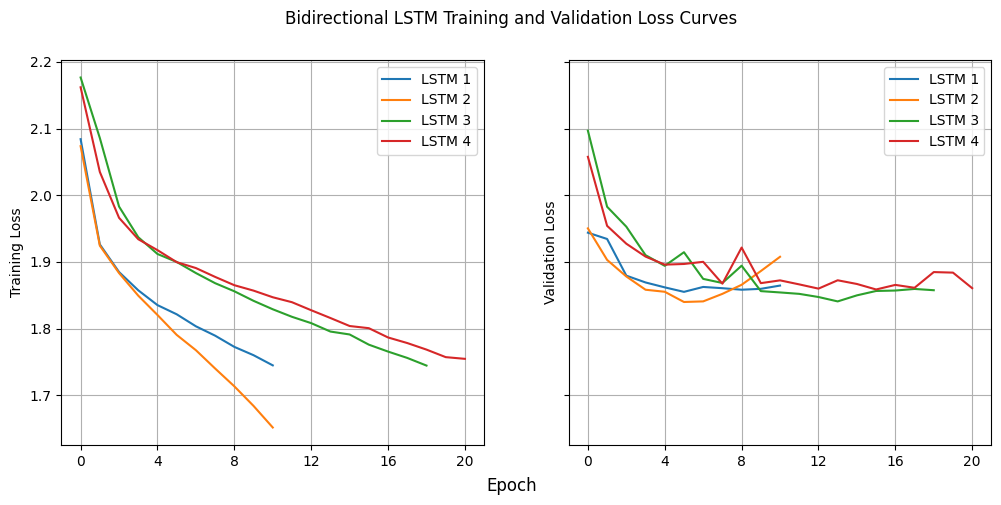

In [22]:
# lstm training/validation loss curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

ax1.plot(lstm_1_history.history['loss'], label='LSTM 1')
ax1.plot(lstm_2_history.history['loss'], label='LSTM 2')
ax1.plot(lstm_3_history.history['loss'], label='LSTM 3')
ax1.plot(lstm_4_history.history['loss'], label='LSTM 4')
ax1.legend()
ax1.set_xticks([i for i in range(21) if i % 4 == 0])
ax1.set_ylabel('Training Loss')
ax1.grid()

ax2.plot(lstm_1_history.history['val_loss'], label='LSTM 1')
ax2.plot(lstm_2_history.history['val_loss'], label='LSTM 2')
ax2.plot(lstm_3_history.history['val_loss'], label='LSTM 3')
ax2.plot(lstm_4_history.history['val_loss'], label='LSTM 4')
ax2.legend()
ax2.set_xticks([i for i in range(21) if i % 4 == 0])
ax2.set_ylabel('Validation Loss')
ax2.grid()

fig.suptitle('Bidirectional LSTM Training and Validation Loss Curves')
fig.supxlabel('Epoch')
plt.show()

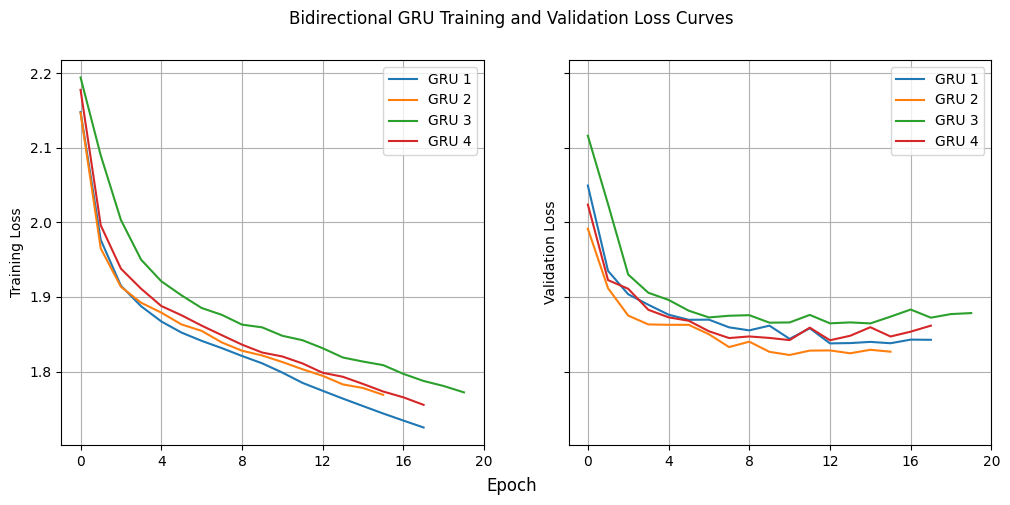

In [23]:
# gru training/validation loss curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

ax1.plot(gru_1_history.history['loss'], label='GRU 1')
ax1.plot(gru_2_history.history['loss'], label='GRU 2')
ax1.plot(gru_3_history.history['loss'], label='GRU 3')
ax1.plot(gru_4_history.history['loss'], label='GRU 4')
ax1.legend()
ax1.set_xticks([i for i in range(21) if i % 4 == 0])
ax1.set_ylabel('Training Loss')
ax1.grid()

ax2.plot(gru_1_history.history['val_loss'], label='GRU 1')
ax2.plot(gru_2_history.history['val_loss'], label='GRU 2')
ax2.plot(gru_3_history.history['val_loss'], label='GRU 3')
ax2.plot(gru_4_history.history['val_loss'], label='GRU 4')
ax2.legend()
ax2.set_xticks([i for i in range(21) if i % 4 == 0])
ax2.set_ylabel('Validation Loss')
ax2.grid()

fig.suptitle('Bidirectional GRU Training and Validation Loss Curves')
fig.supxlabel('Epoch')
plt.show()

## Takeaways

- The bidirectional RNN models have a slight but noticable improvement in performance compared to all other model types
- The best models have validation accuracy around **38%** and loss around **1.82**
- There is still overfitting to the training data in all cases which was reduced but not eliminated with dropout
- Architectures with mixed bidirectional and unidirectional layers performed worse than only bidirectional layers